In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
#import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from epi.models import Parameter, Model
from epi.normalizing_flows import NormalizingFlow
from epi.util import pairplot, AugLagHPs
import tensorflow as tf
from epi.SSSN import SSSN_sim, SSSN_sim_traj, ISN_coeff
#from epi.SSSN import SSSN_sim_tfp
from epi.SSSN import load_SSSN_variable, get_Fano
from epi.util import plot_T_x


neuron_inds = {'E':0, 'P':1, 'S':2, 'V':3}
figdir = "/Users/seanbittner/Documents/epi/written/V1_model/figs/FigSX/"

In [2]:
black = np.array([0, 0, 0])
blue = '#4769A0'
red = '#AF3A31'
green = '#287C5A'
colors = [black, blue, red, green]

In [5]:
ind = 62
W_mat = load_SSSN_variable('W', ind=ind)
hb = load_SSSN_variable('hb', ind=ind)
hc = load_SSSN_variable('hc', ind=ind)

lim = 0.25
lb = -lim*np.ones((4,))
ub =  lim*np.ones((4,))
h = Parameter("h", 4, lb=lb, ub=ub)
parameters = [h]

if ind == 49:
    sigma_eps = np.array([.015, .015, .015, .015])[None,:]
elif ind == 62:
    sigma_eps = np.array([0.00137919, 0.00202632, 0.00074385, 0.00485482])[None,:]

# Define model
name = "SSSN"
model = Model(name, parameters)


0 nans, 0 infs


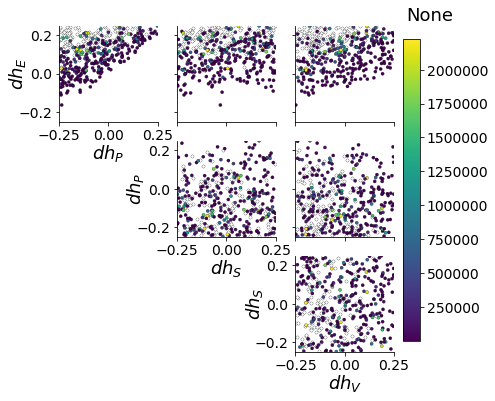

In [6]:
D = 4

dt = 0.0005
T = 150
N = 50

M = 1000

alphas = ['E']
for i, alpha in enumerate(alphas):
    c = 0.5
    name = ""
    neuron_ind = neuron_inds[alpha]

    _h = hb[None,:] + c*hc[None,:]
    sssn_sim_traj = SSSN_sim_traj(sigma_eps, W_mat, N=50, dt=0.0005, T=150)
    _z = np.zeros((M, D))
    for d in range(D):
        _z[:,d] = np.random.uniform(lb[d], ub[d], (M,))
    x_t = sssn_sim_traj(_z+_h).numpy()
    num_nans = np.sum(np.isnan(x_t))
    num_infs = np.sum(np.isinf(x_t))
    print('%d nans, %d infs' % (num_nans, num_infs))
    max_vals = np.amax(np.amax(np.amax(np.abs(x_t), axis=3), axis=2), axis=1)
    plot_inds = max_vals > 100
    
    z_labels = [r'$dh_E$', r'$dh_P$', r'$dh_S$', r'$dh_V$']
    fig = pairplot(_z[plot_inds], np.arange(4), 
                   z_labels, figsize=(6,6), c=max_vals[plot_inds],
                   fontsize=18, lb=lb, ub=ub, labelpads=(0,-10))
    


In [38]:
print(x_t.shape)

(1000, 50, 8, 151)


In [22]:
fano = get_Fano('E', sigma_eps, W_mat, N=250, dt=dt, T=T, T_ss=T-50, mu=accept_mean, k=100.)
model.set_eps(fano)
    
for i in range(100):
    T_x = model.eps(_h+np.array([[0., 0., 0., 0.]]))
    print(T_x)

tf.Tensor([[1.0091287  0.25921202]], shape=(1, 2), dtype=float32)
tf.Tensor([[0.9580551  0.20981446]], shape=(1, 2), dtype=float32)
tf.Tensor([[0.89369285 0.15499406]], shape=(1, 2), dtype=float32)
tf.Tensor([[0.98249424 0.23280069]], shape=(1, 2), dtype=float32)
tf.Tensor([[1.0693156 0.3241202]], shape=(1, 2), dtype=float32)
tf.Tensor([[0.9705494  0.22141674]], shape=(1, 2), dtype=float32)
tf.Tensor([[0.93460596 0.18888234]], shape=(1, 2), dtype=float32)
tf.Tensor([[1.0480413  0.30034932]], shape=(1, 2), dtype=float32)
tf.Tensor([[1.0002065 0.2502065]], shape=(1, 2), dtype=float32)
tf.Tensor([[0.93158466 0.18626532]], shape=(1, 2), dtype=float32)
tf.Tensor([[0.95112973 0.20351803]], shape=(1, 2), dtype=float32)
tf.Tensor([[0.9980809  0.24808459]], shape=(1, 2), dtype=float32)
tf.Tensor([[0.9859727  0.23616947]], shape=(1, 2), dtype=float32)
tf.Tensor([[0.93881196 0.19255593]], shape=(1, 2), dtype=float32)
tf.Tensor([[1.0157835  0.26603267]], shape=(1, 2), dtype=float32)
tf.Tensor([[0.

In [23]:
print(hb)
print(hc)
print(_h)

tf.Tensor([0.45820653 0.35386333 0.33868814 0.5592106 ], shape=(4,), dtype=float32)
tf.Tensor([0.30076382 0.02270158 0.         0.        ], shape=(4,), dtype=float32)
tf.Tensor([[0.60858846 0.3652141  0.33868814 0.5592106 ]], shape=(1, 4), dtype=float32)


In [ ]:
D = 4
neuron_inds = {'E':0, 'P':1, 'S':2, 'V':3}
def accept_inds(T_x, mean, std):
    inds = np.logical_and(mean -2*std < T_x[:,0], 
                          T_x[:,0] < mean + 2*std)
    return inds

accept_mean = .5
#accept_means = [0.]
accept_std = 0.05

dt = 0.0005
T = 150
N = 50

alphas = ['E']
num_alphas = len(alphas)
num_keep = 500
num_plot = num_keep
M = 1000
zs = []
T_xs = []
#cs = {'P':0.2857276499271393, 'S':0.45115533471107483}
#cs = {'P':0.28338050842285156, 'S':0.4607696533203125}
for i, alpha in enumerate(alphas):
    c = 0.5
    name = ""
    neuron_ind = neuron_inds[alpha]

    _h = hb[None,:] + c*hc[None,:]
    fano = get_Fano(alpha, sigma_eps, W_mat, N=N, dt=dt, T=T, T_ss=T-50, mu=accept_mean, k=100.)
    model.set_eps(fano)

    num_found = 0
    z = None
    T_x = None
    count = 0
    while (num_found < num_keep):
        count += 1
        _z = np.zeros((M, D))
        for d in range(D):
            _z[:,d] = np.random.uniform(lb[d], ub[d], (M,))
        _T_x = model.eps(_h+_z).numpy()

        inds = accept_inds(_T_x, accept_mean, accept_std)
        _z = _z[inds, :]
        _T_x = _T_x[inds, :]
        num_found += _z.shape[0]

        if (z is None):
            z = _z
            T_x = _T_x
        else:
            z = np.concatenate((z, _z), axis=0)
            T_x = np.concatenate((T_x, _T_x), axis=0)
        print('%s: %d %d/%d\r' % (alpha, count, num_found, num_keep), end='')

    num_found = z.shape[0]

    # reduce to num_keep
    z = z[:num_keep]
    T_x = T_x[:num_keep]
    zs.append(z)
    T_xs.append(T_x)

    #isn_coeffs = ISN_coeff(z, H[None,:]).numpy()

    z_labels = [r'$dh_E$', r'$dh_P$', r'$dh_S$', r'$dh_V$']
    fig = pairplot(z[:num_plot], np.arange(4), z_labels, figsize=(6,6),
                   c=T_x[:num_plot,0],
                   fontsize=18, lb=lb, ub=ub, labelpads=(0,-10))
    #plt.savefig(figdir + name + '_z.png')

    T_x_sim = model.eps(_h+z).numpy()

    plot_T_x(T_x[:,0], T_x_sim[:,0], x_mean=accept_mean, x_std=accept_std, 
             xlabel=r'$\delta x_%s / \delta h_%s$' % (alpha, alpha), fontsize=30)
    plt.tight_layout()
    #plt.savefig(figdir + name + '_Tx.png')

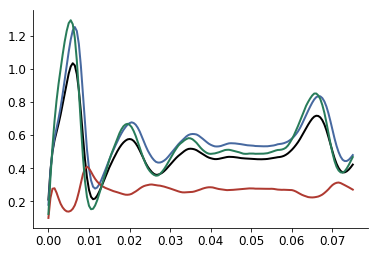

In [36]:
dt = 0.0005
T = 150
t = dt*np.arange(T+1)
sssn_sim_traj = SSSN_sim_traj(sigma_eps, W_mat, N=5, dt=dt, T=T)
x_t = sssn_sim_traj(_h).numpy()
for j in range(4):
    plt.plot(t, x_t[0,1,j,:], c=colors[j])

In [35]:
mode_inds1 = z[:,1] > 0
mode_inds2 = z[:,1] < 0
z_modes1 = z[mode_inds1]
z_modes2 = z[mode_inds2]

[ 0.20530003  0.23749538  0.12588332 -0.19602876]


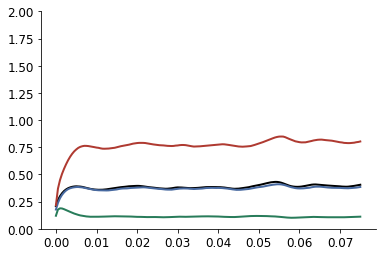

[-0.02956885 -0.02972254  0.14179708 -0.17405424]


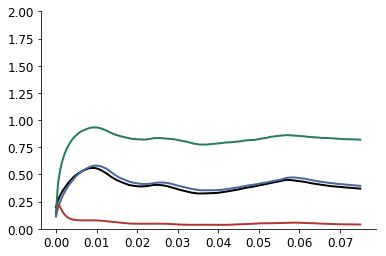

[ 0.19213669  0.19928368 -0.14945444 -0.01500562]


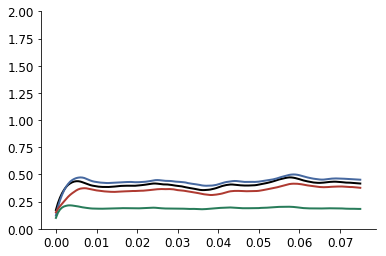

[ 0.11904991  0.13272603  0.10003655 -0.0346124 ]


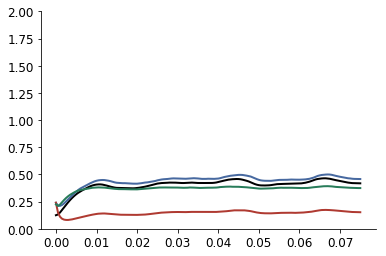

In [52]:
for i in range(4):
    x_t = sssn_sim_traj(_h+z_modes2[i][None]).numpy()
    print(z[i])
    plt.figure()
    for j in range(4):
        #print(z_modes[i])
        plt.plot(t, x_t[0,0,j,:], c=colors[j])
    plt.ylim([0, 2])
    plt.show()


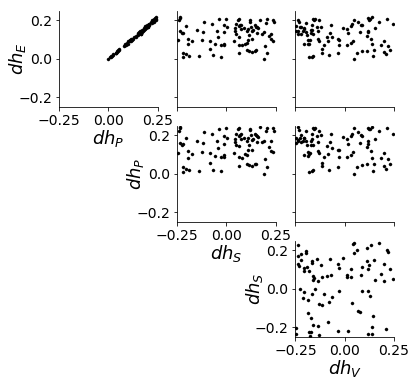

In [46]:
fig = pairplot(z_modes1[:num_plot], np.arange(4), z_labels, figsize=(6,6),
                   fontsize=18, lb=lb, ub=ub, labelpads=(0,-10))

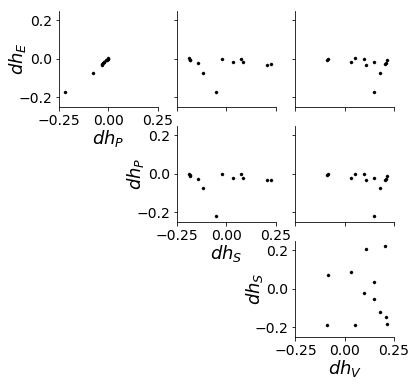

In [47]:
fig = pairplot(z_modes2[:num_plot], np.arange(4), z_labels, figsize=(6,6),
                   fontsize=18, lb=lb, ub=ub, labelpads=(0,-10))
